## Spark cluster intro Air quality examples

### Initialization
Create and attach cluster created in EMR. 

The important configuration options:
 - Amazon EMR version: emr-7.1.0
 - Installed applications: JupyterHub 1.5.0
 - Logs in Amazon S3: disabled
 - Service role for Amazon EMR: EMR_DefaultRole 
 - EC2 instance profile: EMR_EC2_DefaultRole
 - EC2 security groups (firewall): open ports 9443, 18080
 
Login: jovyan, password: jupyter

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1730821505026_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1730821505026_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1730821505026_0004,pyspark,idle,Link,Link,None,✔


In [3]:
# run once per session to install additional packages
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1730821505026_0004/container_1730821505026_0004_01_000001/tmp/spark-d7cf1d2c-282b-44ce-b3cd-9fdf335250d0
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [53]:
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt
import pandas as pd
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading data from AWS S3

Now we can read a small sample of data:

In [5]:
start = time.time()

smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

102.24468278884888

In [6]:
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [7]:
start = time.time()
smog_df.count()
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

21.08136796951294

In [8]:
smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [9]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Simple queries

In [10]:
smog_df.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|location_id|sensors_id|            location|            datetime|      lat|      lon|parameter|units|  value|
+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|50.349608|18.236575|     pm10|µg/m³|  15.62|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|50.349608|18.236575|     pm10|µg/m³|13.6041|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|50.349608|18.236575|     pm10|µg/m³|13.7349|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|50.349608|18.236575|     pm10|µg/m³|15.1872|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T05:00:...|50.349608|18.236575|     pm10|µg/m³|13.0822|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T06:00:...|50.349608|18.236575|     pm10|µg/m³|14.0526|
|

In [39]:
smog_df.select(max("datetime")).first()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(max(datetime)='2022-06-01T00:00:00-08:00')

In [12]:
smog_df.select('parameter').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|parameter|
+---------+
|       co|
|     pm10|
|      so2|
|      no2|
|       bc|
|     pm25|
|       o3|
+---------+

In [13]:
from pyspark.sql.functions import col, asc, desc, max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Some more interesting statistics

In [14]:
start = time.time()
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+-----------+
|location                                        |max_pm10   |
+------------------------------------------------+-----------+
|Ballygunge, Kolkata - WBPCB-10918               |9999.9     |
|Govt. High School Shikarpur, Patna - BSPCB-10630|5631.1     |
|Sanjay Nagar, Ghaziabad - UPPCB-10919           |3490.0     |
|New Industrial Town, Faridabad - HSPCB-10920    |2217.0     |
|Mundka, Delhi - DPCC-10486                      |1787.0     |
|Sector 30, Faridabad - HSPCB-10820              |1309.16    |
|Nedre Langgate-10492                            |1187.386375|
|Mini Secretariat, Charkhi Dadri - HSPCB-10725   |1186.4     |
|Sector 11, Faridabad - HSPCB-10908              |1090.9     |
|Rajbansi Nagar, Patna - BSPCB-10599             |1003.2     |
|Sector-51, Gurugram - HSPCB-10825               |999.99     |
|Murthal, Sonipat - HSPCB-10906                  |999.99     |
|Rishi Nagar, Kaithal - HSPCB-10905              |999.9

In [15]:
smog_df.filter(col('location').contains('Krak')).select('location').distinct().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+
|location                        |
+--------------------------------+
|Kraków, ul. Bulwarowa-10516     |
|Kraków, Aleja Krasińskiego-10752|
+--------------------------------+

In [16]:
max_pm10.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location: string (nullable = true)
 |-- max_pm10: double (nullable = true)

In [55]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Axes: ylabel='location'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

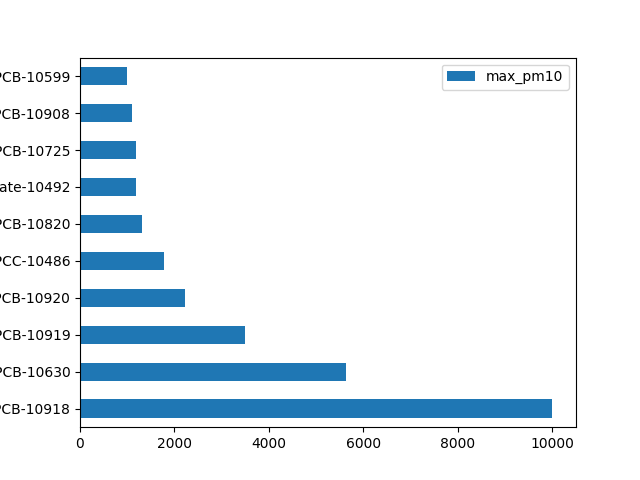

In [56]:
# On EMR we need this magic to show the plot
%matplot plt

# Task 1

Find places in which average pm25 was lower that maximal pm25 at some fixed location

In [19]:
from pyspark.sql.functions import lit

# narrow down the days
limited_day_df = (smog_df.select("location","value")
                  .where(
                        (col("datetime") >= lit("2022-05-17T00:00:000Z")) & 
                        (col("datetime") <  lit("2022-05-27T00:00:000Z")))
                  .where((col("parameter") == "pm25"))
                 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# select a unique location
loc = limited_day_df.select('location').first()[0]
loc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Kędzierzyn-Koźle, ul. Śmiałego-10618'

In [21]:
from pyspark.sql.functions import trim

# get the maximal value for the fixed location
fixed_max = (
    limited_day_df
    .where((col("location") == loc))
    .select(max(col("value")))
    .first()[0]
)

fixed_max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

29.205

In [22]:
from pyspark.sql.functions import avg

# geat mean values for unique locations in that time
loc_means = (
    limited_day_df
    .groupBy("location")
    .agg(avg("value").alias("avg_value"))
    .where(col("avg_value") < fixed_max)
    .orderBy(desc("avg_value"))
)

loc_means.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|            location|         avg_value|
+--------------------+------------------+
|Vidayagiri, Bagal...|28.424133333333327|
|ICRISAT Patancher...| 26.91705069124424|
|PWD Juction, Kohi...|26.914473684210527|
|Railway Colony, G...| 26.73091503267974|
|Manali Village, C...|26.636350710900476|
|Ballygunge, Kolka...|26.015131578947372|
|         Arica-10653|24.732142857142858|
|Victoria, Kolkata...|21.438562091503268|
|Bidhannagar, Kolk...| 19.56473333333333|
|Kalyana Nagara, C...|18.763664122137403|
|Rabindra Sarobar,...| 18.64788732394366|
|       Smestad-10894|       17.30180065|
|Vijay Nagar, Rama...| 16.77304964539007|
|Hebbal 1st Stage,...|15.662165898617515|
|Sahilara, Maihar ...| 15.45562091503268|
|Lumpyngngad, Shil...|14.515797101449275|
|Radomsko, ul. Rol...|12.165562913907285|
|Kacheripady, Erna...|12.155038759689923|
|Kalisz, ul. Wyszy...|12.104100061349692|
|       Alnabru-10495|11.757142857142858|
+--------------------+------------

# Task 2

Highest pm10 per hour for given location

In [23]:
limited_day_df_10 = (smog_df.select("location","datetime","value")
                  .where(
                        (col("datetime") >= lit("2022-05-17T00:00:000Z")) & 
                        (col("datetime") <  lit("2022-05-27T00:00:000Z")))
                  .where((col("parameter") == "pm10"))
                 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
from datetime import datetime, timezone
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import udf

def convert_to_utc(nice_time_str):
    local_dt = datetime.fromisoformat(nice_time_str)
    utc_dt = local_dt.astimezone(timezone.utc)
    return utc_dt.replace(minute=0, second=0, microsecond=0)

convert_time = udf(convert_to_utc , TimestampType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
results = (
    limited_day_df_10
    .where(col("location") == loc)
    .withColumn("datetime", convert_time("datetime"))
    .groupBy("datetime")
    .agg(max("value").alias("max_pm10"))
    .na.drop()
    .orderBy("datetime")
)

results.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------+
|           datetime|max_pm10|
+-------------------+--------+
|2022-05-16 23:00:00|   15.62|
|2022-05-17 00:00:00| 13.6041|
|2022-05-17 01:00:00| 13.7349|
|2022-05-17 02:00:00| 15.1872|
|2022-05-17 03:00:00| 13.0822|
|2022-05-17 04:00:00| 14.0526|
|2022-05-17 05:00:00| 19.2821|
|2022-05-17 06:00:00| 18.9368|
|2022-05-17 07:00:00| 15.2887|
|2022-05-17 08:00:00| 44.2069|
+-------------------+--------+
only showing top 10 rows

# Task 3

Rank for average n highest measurements

In [26]:
n = 5

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, desc

window = Window.partitionBy("location").orderBy("value")
    
df_ranked = (
    limited_day_df
    .select("location", "value")
    .na.drop()
    .withColumn("rank", rank().over(window))
)

df_avg_ranked = (
    df_ranked
    .select("location", "value")
    .where(col("rank") <= n)
    .groupBy("location")
    .agg(avg("value").alias("value_5_day_avg"))
    .orderBy(desc("value_5_day_avg"))
)

df_avg_ranked.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|            location|   value_5_day_avg|
+--------------------+------------------+
|Padre Las Casas I...|45.833333333333336|
|Rohini, Delhi - D...|              30.6|
|ITO, Delhi - CPCB...|              26.0|
|T T Nagar, Bhopal...|25.333333333333332|
|Samanpura, Patna ...|22.660000000000004|
|Rajbansi Nagar, P...|             22.06|
|Narela, Delhi - D...|              21.6|
|Chhoti Gwaltoli, ...|              21.2|
|         Arica-10653|19.928571428571427|
|Palayam, Kozhikod...|19.571428571428573|
|Najafgarh, Delhi ...|19.166666666666668|
|Sri Aurobindo Mar...|              18.8|
|NISE Gwal Pahari,...|18.374000000000002|
|Mundka, Delhi - D...|              17.4|
|Thavakkara, Kannu...|            16.788|
|Sanjay Nagar, Gha...|              15.8|
|Marhatal, Jabalpu...|              15.0|
|Sector-12, Karnal...|            14.864|
|City Center, Gwal...|14.833333333333334|
|Rishi Nagar, Kait...|            10.328|
+--------------------+------------

# Task 4

Visualize on map - visualizing average per country is not possible so I'll try to visualize locations from which we have measurements in given time window

In [28]:
sc.install_pypi_package("cartopy")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
lat_long = (smog_df.select("lat","lon","datetime","value")
                  .where(
                        (col("datetime") >= lit("2022-05-17T00:00:000Z")) & 
                        (col("datetime") <  lit("2022-05-27T00:00:000Z")))
                  .where((col("parameter") == "pm25"))).toPandas()
                 

lat = lat_long["lat"].values
long = lat_long["lon"].values

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
lat

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['50.349608', '50.349608', '50.349608', ..., '-36.36926',
       '-36.36926', '-36.36926'], dtype=object)

In [31]:
long

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['18.236575', '18.236575', '18.236575', ..., '146.3133', '146.3133',
       '146.3133'], dtype=object)

In [85]:
import cartopy.crs as crs
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()

plt.scatter(
    x=long,
    y=lat,
    color="r",
    s=1,
    transform=crs.PlateCarree(),
)

plt.show()

# for some reason the image won't plot in jupyter hub on spark cluster
# Using spark magic doesn't help and results in errors

# %matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Task 5

Scaling

In [33]:
from functools import reduce

large_df = reduce(lambda df1, df2: df1.union(df2), [smog_df]*150)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# narrow down the days
limited_day_df = (large_df.select("location","value")
                  .where((col("parameter") == "pm25"))) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
limited_day_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location: string, value: double]

In [36]:
# select a unique location
loc = limited_day_df.select('location').first()[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The cell below takes the most of the computation time, so it will be the one that we'll use for measurements

All other parts of computation for task 1 are computed in less than 1 second

In [47]:
start = time.time()

# get the maximal value for the fixed location
fixed_max = (
    limited_day_df
    .where((col("location") == loc))
    .select(max(col("value")))
    .first()[0]
)

end = time.time()
print(end-start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

382.8026580810547

In [71]:
cores = [1,2,3,4,5,6,7]
times = [594.58,382.80,188,121.85,90.14,68.06,58.64]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

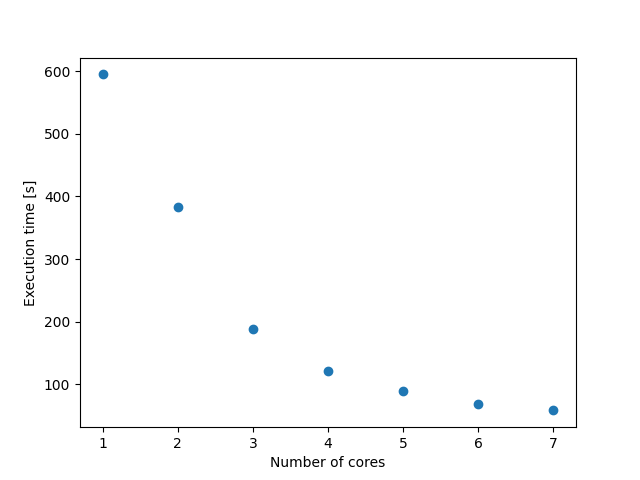

In [73]:
plt.figure()
plt.scatter(cores, times)
plt.xlabel("Number of cores")
plt.ylabel("Execution time [s]")
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

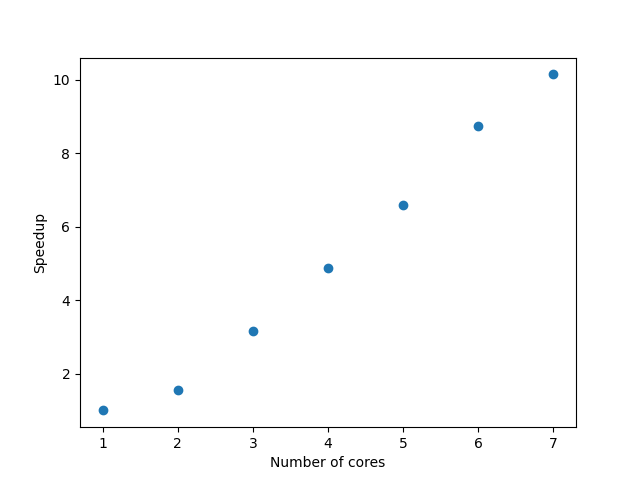

In [77]:
plt.figure()
plt.scatter(cores, [times[0]/t for t in times])
plt.xlabel("Number of cores")
plt.ylabel("Speedup")
plt.show()
%matplot plt

For some reason the speedup is higher than expected. Most probably because of very slow computation of the single core processing

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

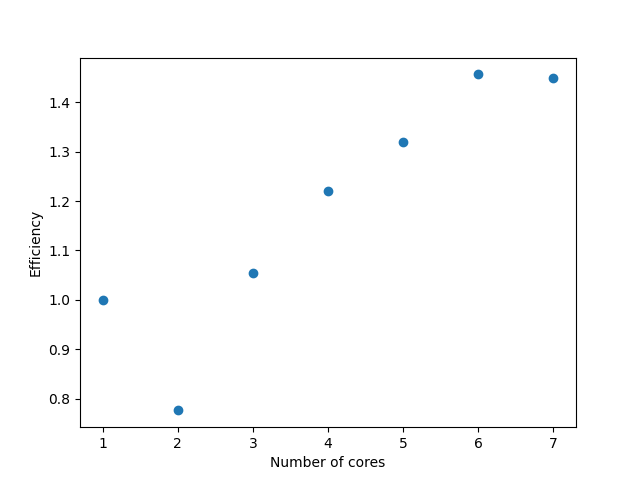

In [82]:
plt.figure()
plt.scatter(cores, [times[0]/(t*c) for t,c in zip(times,cores)])
plt.xlabel("Number of cores")
plt.ylabel("Efficiency")
plt.show()
%matplot plt

# Task 6

Make plots for example task with 2 cores

In [91]:
smog_limited = (smog_df.select("location","value")
              .where(
                    (col("datetime") >= lit("2022-05-17T00:00:000Z")) & 
                    (col("datetime") <  lit("2022-05-27T00:00:000Z")))
              .where((col("parameter") == "pm25")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
smog_limited.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|            location|  value|
+--------------------+-------+
|Kędzierzyn-Koźle,...|7.29604|
|Kędzierzyn-Koźle,...|6.15005|
|Kędzierzyn-Koźle,...|7.23389|
|Kędzierzyn-Koźle,...|8.16159|
|Kędzierzyn-Koźle,...|7.60069|
|Kędzierzyn-Koźle,...|8.19521|
|Kędzierzyn-Koźle,...|9.53123|
|Kędzierzyn-Koźle,...| 9.7266|
|Kędzierzyn-Koźle,...| 6.0074|
|Kędzierzyn-Koźle,...|11.8849|
|Kędzierzyn-Koźle,...|8.42319|
|Kędzierzyn-Koźle,...|8.74669|
|Kędzierzyn-Koźle,...|9.94719|
|Kędzierzyn-Koźle,...|12.8582|
|Kędzierzyn-Koźle,...|16.3435|
|Kędzierzyn-Koźle,...|17.6108|
|Kędzierzyn-Koźle,...|5.71142|
|Kędzierzyn-Koźle,...| 2.5442|
|Kędzierzyn-Koźle,...|2.78415|
|Kędzierzyn-Koźle,...|2.59362|
+--------------------+-------+
only showing top 20 rows

---

![](dag_for_2_jobs.png)

![](task_for_2_jobs.png)